In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


In [2]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [3]:
torch.cuda.is_available()

True

In [4]:
# clear memory of cuda
torch.cuda.empty_cache()

In [5]:
NUM_DEVICES = torch.cuda.device_count()

In [6]:
BATCH_SIZE = 32
N_EPOCHS = 20

In [7]:
LR=0.0001

# EDA

In [8]:
train_data='archive1/training'
val_data='archive1/validation'
test_data='archive1/evaluation'

In [9]:
import matplotlib.image as mpimg
def visualize_images(path):
    image_filenames = os.listdir(path)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3),facecolor='white')
    for i, image_filename in enumerate(image_filenames[:5]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].set_title(image_filename)  # Set image filename as title
    plt.show()


In [9]:
CLASSES = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat", "Noodles-Pasta", "Rice", "Seafood", "Soup", "Vegetable-Fruit"]

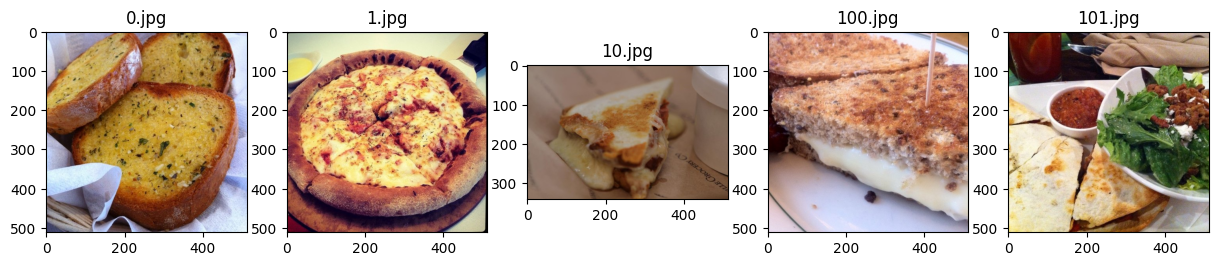

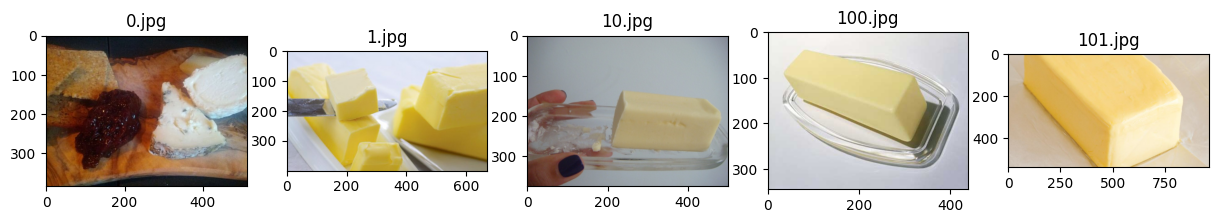

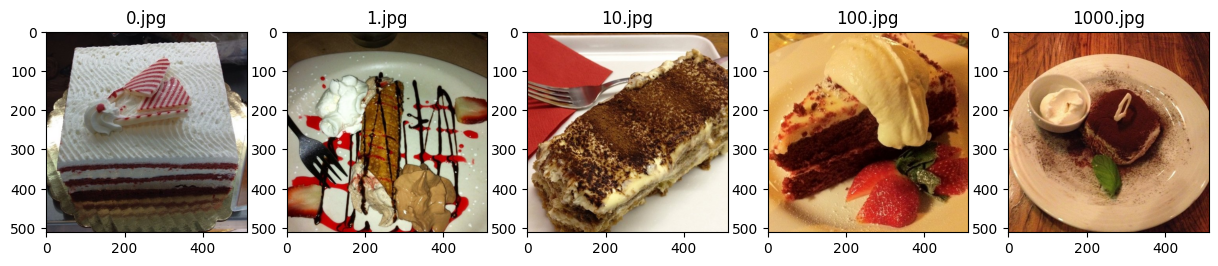

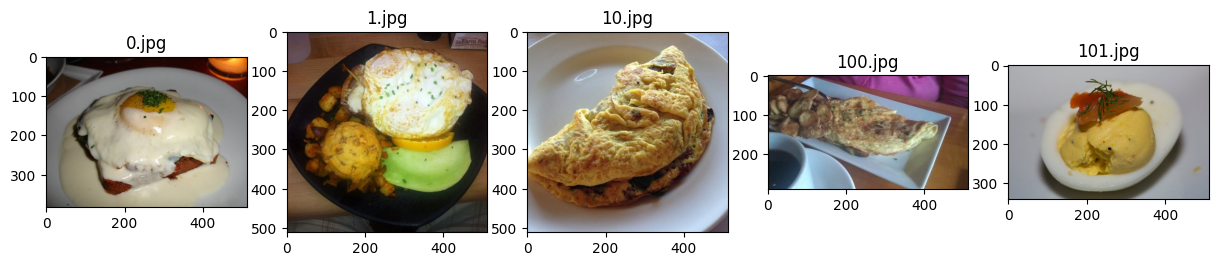

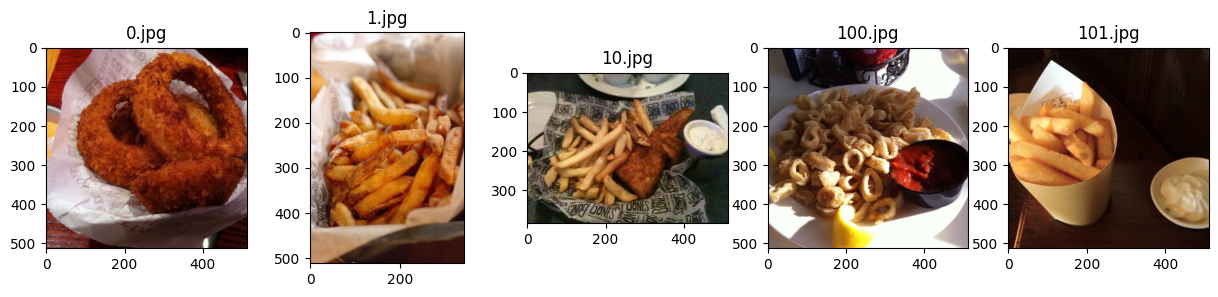

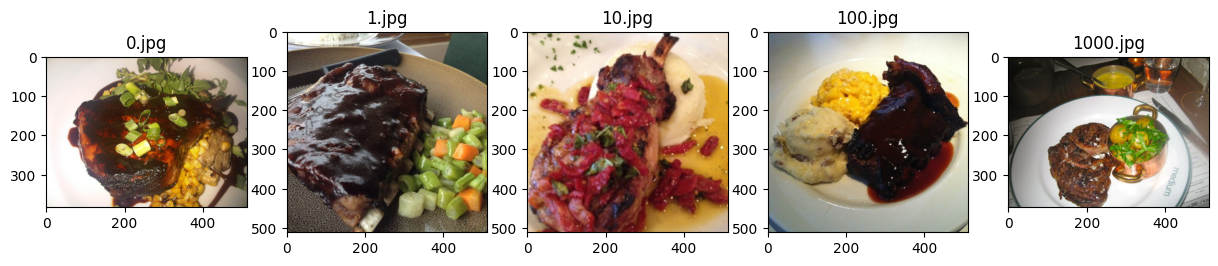

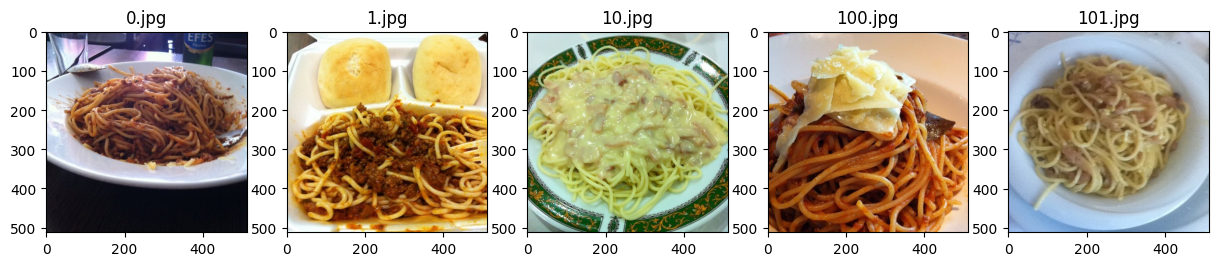

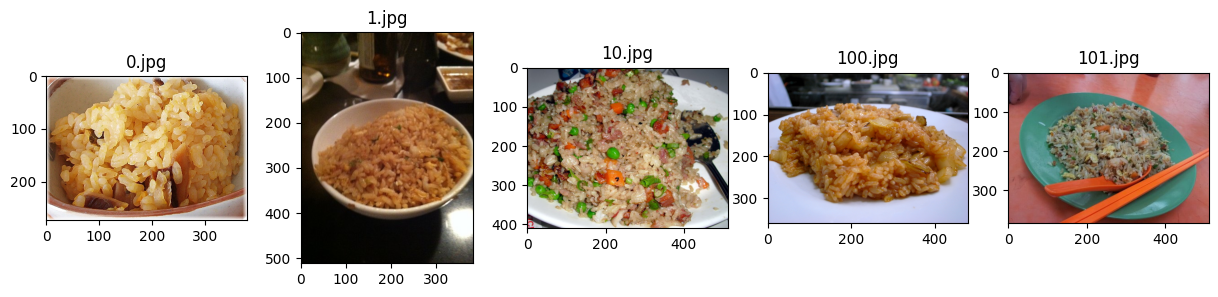

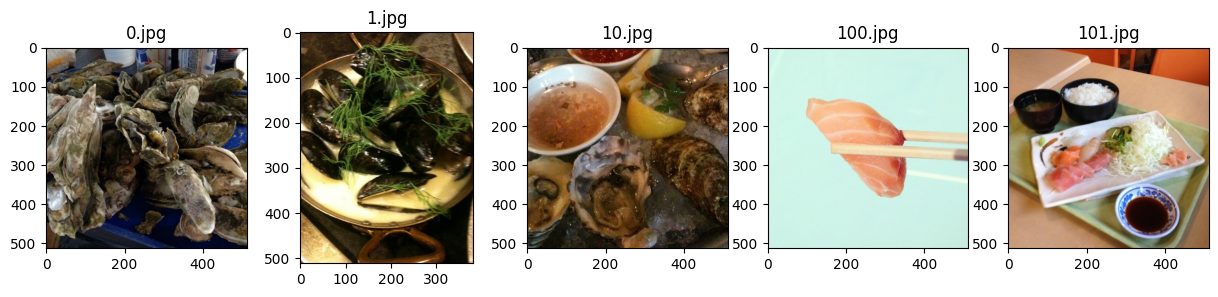

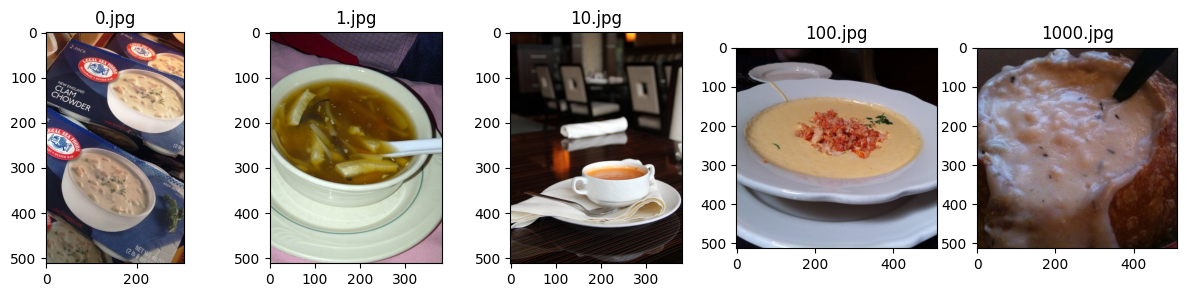

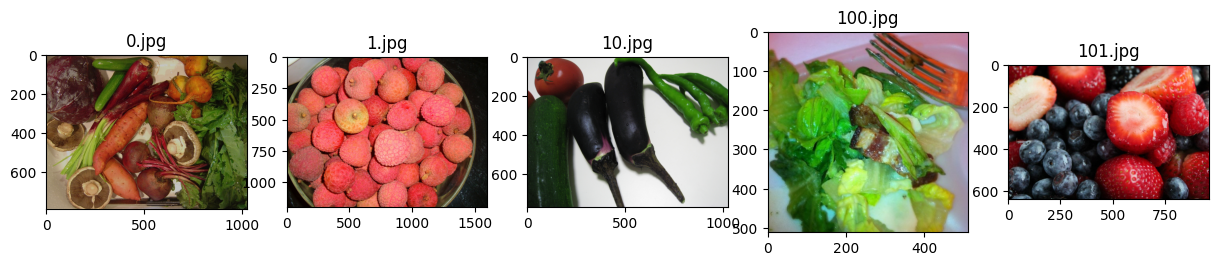

In [25]:
for i in CLASSES:
    visualize_images("archive1\\training\\"+i)

In [10]:
import torchvision
from torchvision import transforms

In [11]:
transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [12]:
from torchvision.datasets import ImageFolder

In [13]:
train_dataset=ImageFolder(root=train_data,transform=transform)
test_dataset=ImageFolder(root=test_data,transform=transform)
val_dataset=ImageFolder(root=val_data,transform=transform)

In [39]:
print("train_dataset size: ",train_dataset.__len__())
print("val_dataset size: ",val_dataset.__len__())
print("test_dataset size: ",test_dataset.__len__())

train_dataset size:  9866
val_dataset size:  3430
test_dataset size:  3347


In [40]:
train_dataset[0][0].shape

torch.Size([3, 200, 200])

In [14]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [58]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(50176, 128),
            nn.Linear(128, 64),
            # nn.ReLU(),
            nn.Linear(64, 11)
        )
    def forward(self, x):
        return self.classifier(x)

In [59]:
classifier=Classifier()

In [60]:
classifier

Classifier(
  (classifier): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=128, bias=True)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [66]:
error=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier.parameters(), lr=LR)

In [62]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
torch.cuda.is_available()
torch.cuda.current_device()

0

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = classifier.to(device)


In [ ]:
val_losses=[]
train_losses=[]
accuracies=[]
val_accuracies=[]

for epoch in range(N_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = classifier(images)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i % 100 == 0:
            print("Epoch:", epoch, "Iteration:", i, "Loss:", loss.item())

    # Calculate validation accuracy
    val_accuracy = get_accuracy(classifier, val_loader)
    val_accuracies.append(val_accuracy)

    # Calculate training accuracy
    train_accuracy = get_accuracy(classifier, train_loader)
    accuracies.append(train_accuracy)

print("Validation Accuracy:", val_accuracy)
print("Training Accuracy:", train_accuracy)




In [67]:
torch.cuda.empty_cache()

In [69]:
# get the model accuracy
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in data_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [103]:
get_accuracy(classifier, val_loader)

0.1457725947521866

In [71]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [72]:
evaluate_model(classifier, train_loader, device)

accuracy: 83.03


In [73]:
evaluate_model(classifier, val_loader, device)

accuracy: 44.75


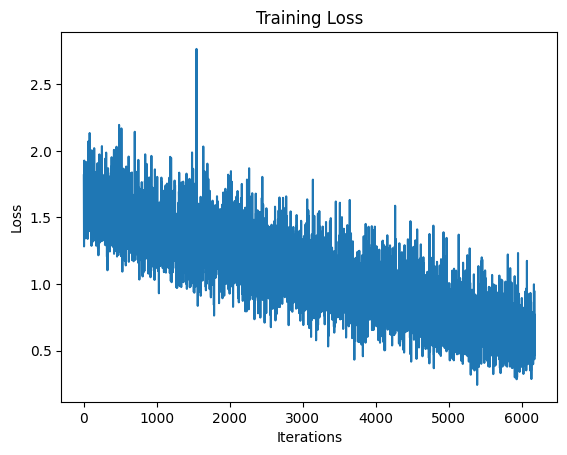

In [74]:
plt.plot(train_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


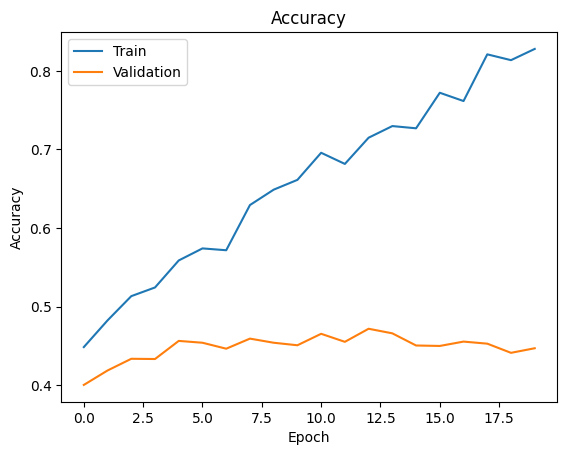

In [75]:
plt.plot(accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


In [76]:
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)
evaluate_model(classifier, test_loader, device)


accuracy: 48.88
